## Fine-Tuning CLIP Models

In this notebook, we will look at how you can fine-tune a CLIP model for image classification.

Note: before you start, ensure your runtime is set to GPU. If you're unsure on how to do that, visit this [article](https://www.marqo.ai/blog/getting-started-with-google-colab-a-beginners-guide).

### **1. Install Relevant Libraries**

We first install relevant modules

In [1]:
# Stops output in Colab. Remove this if you wish.
%%capture

!pip install openai-clip
!pip install datasets
!pip install torch
!pip install tqdm

We will be using `openai-clip` to define our base CLIP model and utilising `datasets` provided by Hugging Face. The library `torch` will be used to facilitate model loading, device management, tensor manipulation, and inference. Finally, `tqdm` is used to track the progress of the fine-tuning.

Now we've installed the libraries needed to fine-tune, we must obtain a dataset to perform this fine-tuning.

### **2. Load a Dataset**

To perform fine-tuning, we will use a small image classification dataset. We’ll use the `ceyda/fashion-products-small` dataset which is a collection of fashion products.

In [2]:
# Stops output in Colab. Remove this if you wish.
%%capture

from datasets import load_dataset

# Load the dataset
ds = load_dataset('ceyda/fashion-products-small')

Let's take a look at the features inside this dataset:

In [3]:
ds

DatasetDict({
    train: Dataset({
        features: ['filename', 'link', 'id', 'masterCategory', 'gender', 'subCategory', 'image'],
        num_rows: 42700
    })
})

We see that we have `filename`, `link`, `id`, `masterCategory`, `gender`, `subCategory` and `image`. Let's print the first example from this dataset to see what these features mean:

In [4]:
entry = ds['train'][0]
entry

{'filename': '15970.jpg',
 'link': 'http://assets.myntassets.com/v1/images/style/properties/7a5b82d1372a7a5c6de67ae7a314fd91_images.jpg',
 'id': '15970',
 'masterCategory': 'Apparel',
 'gender': 'Men',
 'subCategory': 'Topwear',
 'image': <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=384x512>}

Thus, the features of the dataset are as follows:

* `filename`: this is the filename of the image, indicating that the image is stored or identified with this name.
* `link`: this is a URL link to the actual image file, which is hosted online. This link can be used to view or download the image.
* `id`: this is a unique identifier for the image, which can be used to reference this specific item within the dataset.
* `masterCategory`: this indicates the broad category under which this product falls.
* `gender`: this specifies the intended gender for the product, in this case, men's clothing.
* `subCategory`: this is a more specific category within the master category. "Topwear" indicates that the product is an item of clothing worn on the upper body, such as a shirt, t-shirt, or jacket.
* `image`: this is a PIL (Python Imaging Library) image object, which allows for image manipulation and processing. It specifies the image mode (RGB, meaning it has red, green, and blue color channels) and the image size (384 pixels wide by 512 pixels tall).

Cool, let’s look at the image!

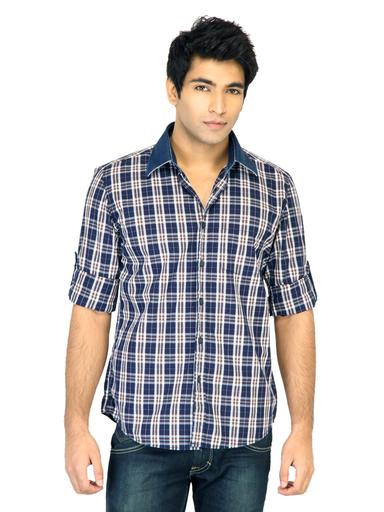

In [5]:
image = entry['image']
image

As expected, it's an item of men's topwear.

We can see that the data itself is comprised of a train dataset, so we will define our dataset as this.

In [6]:
dataset = ds['train']

Awesome, so now we've seen what our dataset looks like, it's time to load our CLIP model and perform preprocessing.

### **3. Load CLIP Model and Preprocessing**

The CLIP model (`ViT-B/32`) and its preprocessing function are loaded. The model is moved to the appropriate device (GPU if available, otherwise CPU).

In [7]:
# Stops output in Colab. Remove this if you wish.
%%capture

import clip
import torch

# OpenAI CLIP model and preprocessing
model, preprocess = clip.load("ViT-B/32", jit=False)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

Let's take a look at how well our base CLIP model performs image classification on this dataset.

This code uses the CLIP model to classify three example images from our dataset by comparing their visual features with textual descriptions of subcategories. It processes and normalizes the features of the images and subcategory texts, calculates their similarity, and predicts the subcategory for each image. Finally, it visualizes the images alongside their predicted and actual subcategories in a plot.

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/conv.py:456: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return F.conv2d(input, weight, bias, self.stride,


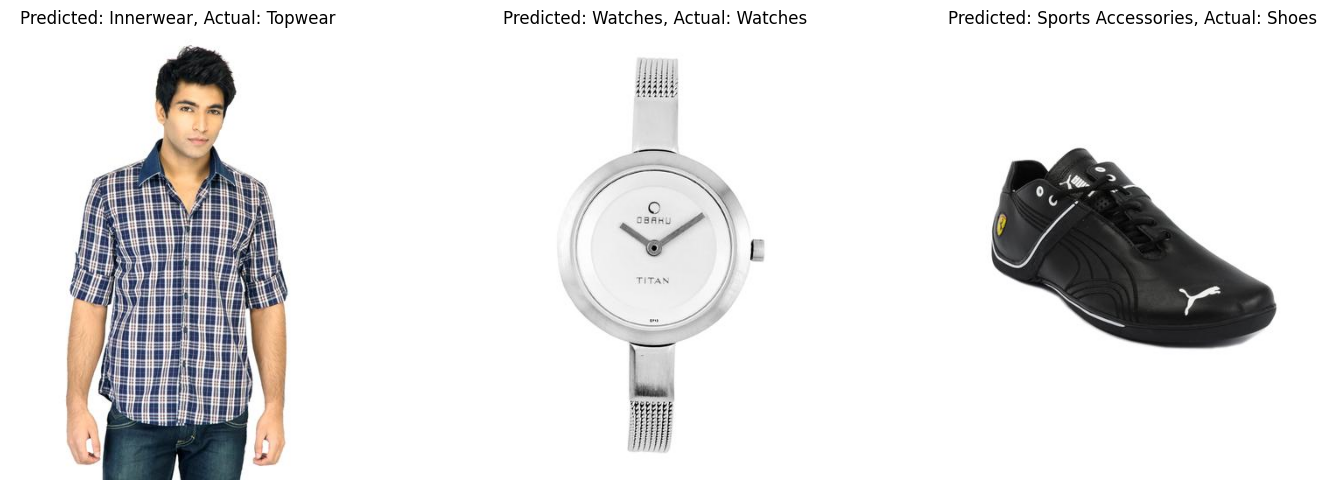

In [8]:
import matplotlib.pyplot as plt

# Select indices for three example images
indices = [0, 2, 10]

# Get the list of possible subcategories from the dataset
subcategories = list(set(example['subCategory'] for example in dataset))

# Preprocess the text descriptions for each subcategory
text_inputs = torch.cat([clip.tokenize(f"a photo of {c}") for c in subcategories]).to(device)

# Create a figure with subplots
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# Loop through the indices and process each image
for i, idx in enumerate(indices):
    # Select an example image from the dataset
    example = dataset[idx]
    image = example['image']
    subcategory = example['subCategory']

    # Preprocess the image
    image_input = preprocess(image).unsqueeze(0).to(device)

    # Calculate image and text features
    with torch.no_grad():
        image_features = model.encode_image(image_input)
        text_features = model.encode_text(text_inputs)

    # Normalize the features
    image_features /= image_features.norm(dim=-1, keepdim=True)
    text_features /= text_features.norm(dim=-1, keepdim=True)

    # Calculate similarity between image and text features
    similarity = (100.0 * image_features @ text_features.T).softmax(dim=-1)
    values, indices = similarity[0].topk(1)

    # Display the image in the subplot
    axes[i].imshow(image)
    axes[i].set_title(f"Predicted: {subcategories[indices[0]]}, Actual: {subcategory}")
    axes[i].axis('off')

# Show the plot
plt.tight_layout()
plt.show()

As we can see for the three images, our base CLIP model does not perform very well. It only identifies one of the three images correctly.

Let's set up the process for fine-tuning our CLIP model to improve these predictions.

### **4. Processing the Dataset**

First, we must split our dataset into training and validation sets. This step is crucial because it allows us to evaluate the performance of our machine learning model on unseen data, ensuring that the model generalizes well to new, real-world data rather than just the data it was trained on.

We take 80% of the original dataset to train our model and the remaining 20% as the validation data.

In [9]:
from torch.utils.data import random_split

# Split dataset into training and validation sets
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

Next, we create a custom dataset class:

In [10]:
from torchvision import transforms
from torch.utils.data import Dataset

# Define a custom dataset class
class FashionDataset(Dataset):
    def __init__(self, data):
        self.data = data
        self.transform = transforms.Compose([
            transforms.Resize((224, 224)),
            transforms.ToTensor(),
            transforms.Normalize((0.48145466, 0.4578275, 0.40821073), (0.26862954, 0.26130258, 0.27577711))
        ])

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        item = self.data[idx]
        image = item['image']
        subcategory = item['subCategory']
        label = subcategories.index(subcategory)
        return self.transform(image), label

Let's break this down:

* **`__init__` method**: Initializes the dataset object with data and sets up a series of transformations to preprocess the images. The transformations include resizing the images to 224x224 pixels, converting them to tensors, and normalizing them with specific mean and standard deviation values.
* **`__len__` method**: Returns the number of samples in the dataset.
* **`__getitem__` method**: Retrieves an image and its corresponding subcategory from the dataset. The image is transformed using the predefined transformations, and the subcategory is converted to a label by finding its index in the subcategories list.

Next, we create DataLoaders:

In [11]:
from torch.utils.data import DataLoader

# Create DataLoader for training and validation sets
train_loader = DataLoader(FashionDataset(train_dataset), batch_size=32, shuffle=True)
val_loader = DataLoader(FashionDataset(val_dataset), batch_size=32, shuffle=False)

Here,
* `train_loader`: A DataLoader for the training set, with a batch size of 32 and shuffling enabled to randomize the order of samples.
* `val_loader`: A DataLoader for the validation set, with a batch size of 32 and shuffling disabled to maintain the order of samples.

Next, we modify the model for fine-tuning:

In [12]:
import torch.nn as nn

# Modify the model to include a classifier for subcategories
class CLIPFineTuner(nn.Module):
    def __init__(self, model, num_classes):
        super(CLIPFineTuner, self).__init__()
        self.model = model
        self.classifier = nn.Linear(model.visual.output_dim, num_classes)

    def forward(self, x):
        with torch.no_grad():
            features = self.model.encode_image(x).float()  # Convert to float32
        return self.classifier(features)

Here,
* **`__init__` method**: Initializes the fine-tuning model with a base CLIP model and a new linear classifier for the subcategories. The linear layer has `num_classes` output units, corresponding to the number of subcategories.
* **`forward` method**: Passes the input images through the base CLIP model to extract features (without updating the base model's weights) and then through the new classifier to predict the subcategory.

Finally, we instantiate the fine-tuning model:

In [13]:
num_classes = len(subcategories)
model_ft = CLIPFineTuner(model, num_classes).to(device)

Here,
* `num_classes`: The number of unique subcategories in the dataset.
* `model_ft`: An instance of the `CLIPFineTuner` class, set up for fine-tuning on the subcategory classification task, and moved to the specified device (CPU or GPU).

Amazing! We've set up everything we need to perform fine-tuning! Let's now define our loss function and optimizer.

### **5. Define Loss Function and Optimizer**

We define as follows:

In [14]:
import torch.optim as optim

# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model_ft.classifier.parameters(), lr=1e-4)

Here,
* `criterion`: The loss function used is Cross-Entropy Loss, which is suitable for multi-class classification tasks.
* `optimizer`: The optimizer used is Adam, applied only to the parameters of the classifier layer (model_ft.classifier.parameters()) with a learning rate of 0.0001.

Great, now we set up the fine-tuning!

### **6. Fine-Tuning CLIP Model**

We are now in a position to perform our fine-tuning.

Let's break down the code in the training loop:

**Training:**

* `num_epochs`: Specifies the number of epochs (iterations over the entire training dataset).
* Training mode: The model is set to training mode using `model_ft.train()`.
* Progress bar: A progress bar (`tqdm`) is used to track the progress of the training loop, displaying the current epoch and running loss.
* Training steps:
  - For each batch of images and labels from `train_loader`:
    - Move the images and labels to the specified device (CPU or GPU).
    - Zero the gradients using `optimizer.zero_grad()`.
    - Forward pass: Compute the model's outputs.
    - Compute the loss using criterion.
    - Backward pass: Compute gradients using `loss.backward()`.
    - Update the model parameters using `optimizer.step()`.
    - Update the running loss.
    - Update the progress bar description with the average loss for the epoch.
- After each epoch, the average loss for the epoch is printed.

**Validation:**
- Evaluation mode: The model is set to evaluation mode using `model_ft.eval()`.
- Accuracy calculation:
  - Disable gradient computation with `torch.no_grad()`.
  - For each batch of images and labels from val_loader:
    - Move the images and labels to the specified device.
    - Forward pass: Compute the model's outputs.
    - Get the predicted labels by finding the class with the highest score using `torch.max`.
    - Update the total number of labels and the count of correct predictions.
  - Calculate and print the validation accuracy as a percentage.

**Save the Fine-Tuned Model:**
The state dictionary of the fine-tuned model is saved to a file named `'clip_finetuned.pth'`.

In [15]:
from tqdm import tqdm

# Number of epochs for training
num_epochs = 5

# Training loop
for epoch in range(num_epochs):
    model_ft.train()  # Set the model to training mode
    running_loss = 0.0  # Initialize running loss for the current epoch
    pbar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}, Loss: 0.0000")  # Initialize progress bar

    for images, labels in pbar:
        images, labels = images.to(device), labels.to(device)  # Move images and labels to the device (GPU or CPU)
        optimizer.zero_grad()  # Clear the gradients of all optimized variables
        outputs = model_ft(images)  # Forward pass: compute predicted outputs by passing inputs to the model
        loss = criterion(outputs, labels)  # Calculate the loss
        loss.backward()  # Backward pass: compute gradient of the loss with respect to model parameters
        optimizer.step()  # Perform a single optimization step (parameter update)

        running_loss += loss.item()  # Update running loss
        pbar.set_description(f"Epoch {epoch+1}/{num_epochs}, Loss: {running_loss/len(train_loader):.4f}")  # Update progress bar with current loss

    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss/len(train_loader):.4f}')  # Print average loss for the epoch

    # Validation
    model_ft.eval()  # Set the model to evaluation mode
    correct = 0  # Initialize correct predictions counter
    total = 0  # Initialize total samples counter

    with torch.no_grad():  # Disable gradient calculation for validation
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)  # Move images and labels to the device
            outputs = model_ft(images)  # Forward pass: compute predicted outputs by passing inputs to the model
            _, predicted = torch.max(outputs.data, 1)  # Get the class label with the highest probability
            total += labels.size(0)  # Update total samples
            correct += (predicted == labels).sum().item()  # Update correct predictions

    print(f'Validation Accuracy: {100 * correct / total}%')  # Print validation accuracy for the epoch

# Save the fine-tuned model
torch.save(model_ft.state_dict(), 'clip_finetuned.pth')  # Save the model's state dictionary

Epoch 1/5, Loss: 1.5473: 100%|██████████| 1068/1068 [02:48<00:00,  6.34it/s]


Epoch [1/5], Loss: 1.5473
Validation Accuracy: 84.7072599531616%


Epoch 2/5, Loss: 0.5738: 100%|██████████| 1068/1068 [02:46<00:00,  6.43it/s]


Epoch [2/5], Loss: 0.5738
Validation Accuracy: 90.46838407494145%


Epoch 3/5, Loss: 0.3802: 100%|██████████| 1068/1068 [02:44<00:00,  6.48it/s]


Epoch [3/5], Loss: 0.3802
Validation Accuracy: 92.08430913348946%


Epoch 4/5, Loss: 0.2997: 100%|██████████| 1068/1068 [02:44<00:00,  6.49it/s]


Epoch [4/5], Loss: 0.2997
Validation Accuracy: 92.79859484777518%


Epoch 5/5, Loss: 0.2565: 100%|██████████| 1068/1068 [02:44<00:00,  6.48it/s]


Epoch [5/5], Loss: 0.2565
Validation Accuracy: 93.44262295081967%


Amazing! Each epoch takes around 3 minutes to run. Since we have 5 epochs, this code takes roughly 15 minutes so go grab yourself a cup of tea ☕️ and come back to see the magic of fine-tuning!

Here's a screenshot of the results we get once fine-tuning is complete. Note, you may get different results when running the code yourself.

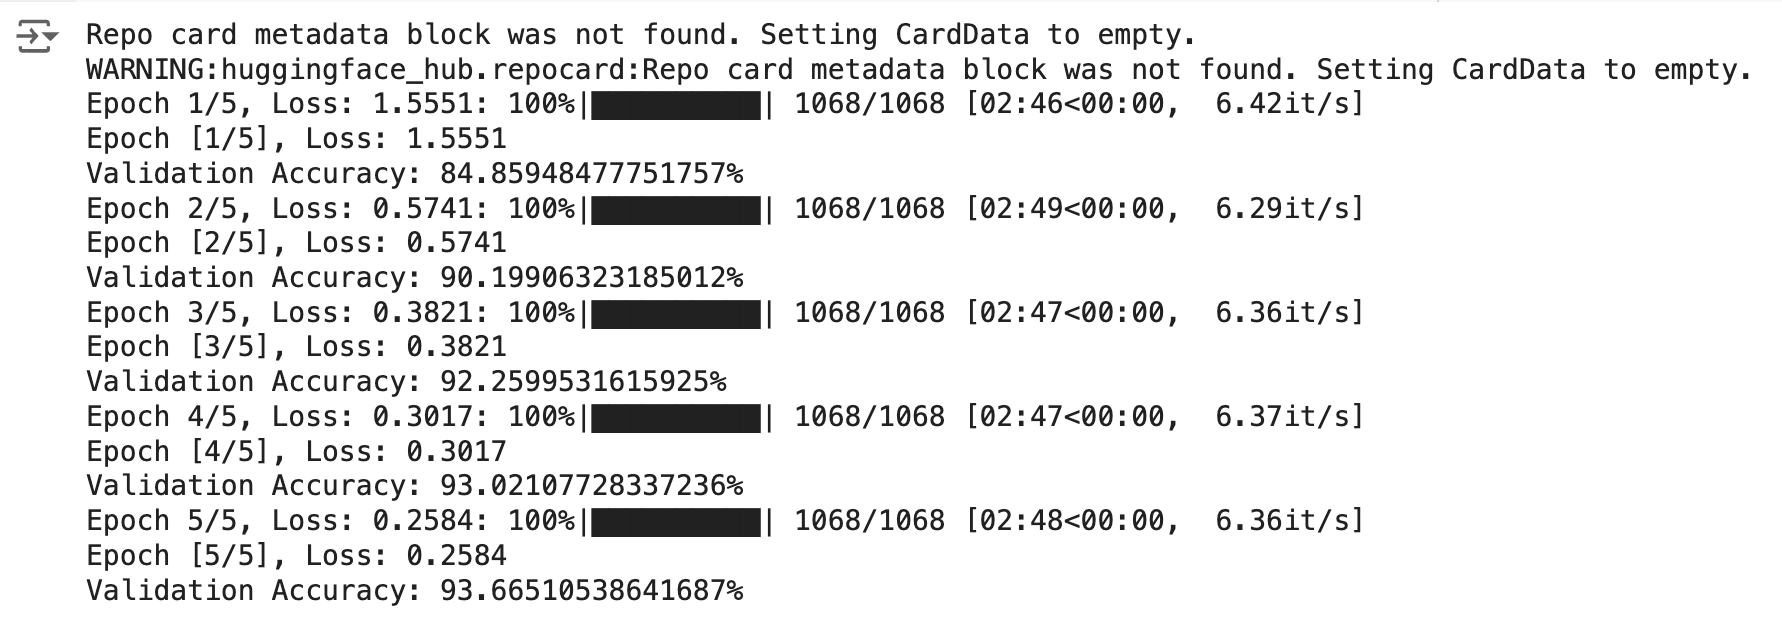

As you can see, the fine-tuning process is successful, with the model showing significant improvements in both training loss and validation accuracy across the epochs. The final validation accuracy of 93.67% is a strong result, indicating that the model has effectively learned from the training data and is performing well on validation data. The gradual decrease in training loss and steady increase in validation accuracy reflect a well-conducted training process with no signs of overfitting or underfitting.

Amazing! Let's now take a look at how our new model performs on the same images we tested earlier.

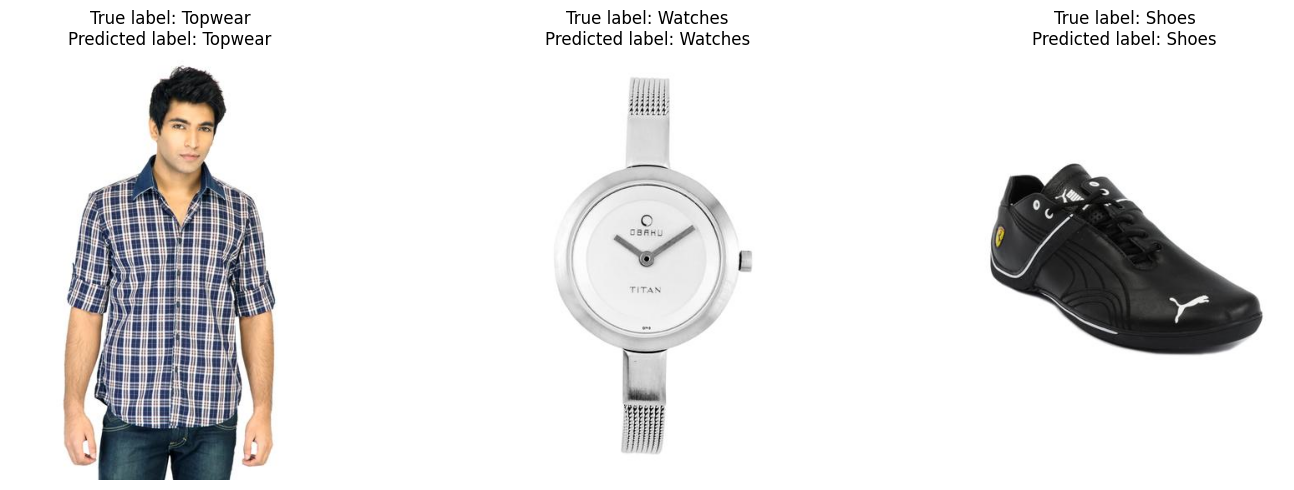

In [16]:
import matplotlib.pyplot as plt
import torch
from torchvision import transforms

# Load the saved model weights
model_ft.load_state_dict(torch.load('clip_finetuned.pth'))
model_ft.eval()  # Set the model to evaluation mode

# Define the indices for the three images
indices = [0, 2, 10]

# Preprocess the image
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize((0.48145466, 0.4578275, 0.40821073), (0.26862954, 0.26130258, 0.27577711))
])

# Create a figure with subplots
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# Loop through the indices and process each image
for i, idx in enumerate(indices):
    # Get the image and label from the dataset
    item = dataset[idx]
    image = item['image']
    true_label = item['subCategory']

    # Transform the image
    image_tensor = transform(image).unsqueeze(0).to(device)  # Add batch dimension and move to device

    # Perform inference
    with torch.no_grad():
        output = model_ft(image_tensor)
        _, predicted_label_idx = torch.max(output, 1)
        predicted_label = subcategories[predicted_label_idx.item()]

    # Display the image in the subplot
    axes[i].imshow(image)
    axes[i].set_title(f'True label: {true_label}\nPredicted label: {predicted_label}')
    axes[i].axis('off')

# Show the plot
plt.tight_layout()
plt.show()

Super cool! Our newly fine-tuned CLIP model successfully predicts the labels for the three images.

Why don't you test out different images and settings to see if you can get even better results!